# Unsupervised Monocular Depth Estimation

# Abstract
The ultimate goal of this project is to produce a depth map given a single input image. The vast majority of attempts approach this in a supervised way, which requires ground truth depth information in the training phase. The downside is that the depth data is not only expensive to collect due to the complicated hardware requirements but also imprecise under various lightning conditions that are inevitable in the natural scene.

"Unsupervised Monocular Depth Estimation with Left-Right Consistency" https://arxiv.org/pdf/1609.03677.pdf by  Clément Godard, Oisin Mac Aodha and Gabriel J. Brostow posed the depth estimation as an image reconstruction problem, which bypasses the needs for the depth information. They achieved this by proposing a fully connected deep neural network, and minimizing loss in appearance matching, disparity smoothness and left-right disparity consistency.


# Introduction

## Network Architecture at High Level

![alt text](https://drive.google.com/uc?id=1bz8aXhrg9VzrWpje2Dyw4AimVqsREKWs)



The training dataset is composed of calibrated stereo images. The left images are denoted as $I^l$, and right images are denoted as $I^r$.

The naïve way is to feed the left image into the fully connected deep neural network which tries to learn the disparity mapping of right image from its left counterpart, and the disparity matrix is denoted as $d^r$. Then, by sampling the left image according to $d^r$, we should synthesize the right image, denoted as ${\tilde{I}}^r$. Finally, we compare with the ground truth right image $I^r$ and backpropagate the loss to update network parameters.

As a monocular depth estimation, the output disparity should be aligned with the single input image so that the naïve approach is not applicable in this case. No LR approach solves this problem by letting the network to learn the disparity map of left image from the right one. In this way, we can recover the left input image by sampling the right input image and compare with the ground truth.

The architecture can be further refined by training the network with the left image so that it produces both disparity maps which then can be compared with stereo pairs. This approach mitigates the “text-copy” artifact from the No LR approach and significantly boosts the result.


 # The detailed of network structure
## Use Yellow Block stands for layers of convolution layers in a resblock_basic
![alt text](https://drive.google.com/uc?id=0Bwv6v6bgdX__UUVvWG5lblF2dU1sa2ZLYTZvWE52VU8yM2FF)
## Use Black Block stands for layers of convolution layers in a resblock_basic
![alt text](https://drive.google.com/uc?id=0Bwv6v6bgdX__a2trdGZtRUtxRHhEUU1xSkF0OGlBaDlDNUpv)
## The Overall Neural Network Structure
![alt text](https://drive.google.com/uc?id=0Bwv6v6bgdX__XzF5aW1sNGVqd01PajdKenNHOG1yWUlPb05R)

## Image Sampler
To synthesize the estimated image from the target’s disparity. The model adopts the image sampler from spatial transformer network (STN). The motivation is that STN chooses bilinear sampling so that it is fully differentiable. 

The code block below demonstrates that, given a left image and disparity map of right image from the left image, we can use grid_sample() to reconstruct the right image. Suppose both left and right images are 3x4x1, and the foreground object on the left image has disparity of 1.

First, we generate the constant flow field without any disparity applied. We can observe that, grid_sample() produces the identical left image. 

Then, we create a disparity map and add it to the flow_field along x-direction (For rectified stereo pairs, objects are shifted along epipolar lines that are parallel along x-direction). The output image is the reconstructed right image. Note that the disparity matrix here is equivalent but not equal to not the pixel-level disparity, but this is not an issuce since it is learned by the network. 



In [0]:
import warnings
warnings.simplefilter("ignore")
import torch

width=4
height=3
left_image = torch.zeros(12).view(3,4)
left_image[:,2]=5
left_image = left_image.view(1,1,3,4).float()
print(f"Example left input image:\n{left_image}")

rows = torch.linspace(0, 1, height)
cols = torch.linspace(0, 1, width)
y, x = torch.meshgrid(rows, cols)

print(f'\nConstruct a constant flow field in x direction:\n{x}')
flow = torch.stack((x,y), dim=2).unsqueeze(0)
output_image_1 = torch.nn.functional.grid_sample(left_image, 2*flow-1, mode='bilinear', padding_mode='zeros')
print(f'\nThe output image should look identical to the left input image:\n{output_image_1}')

print('----------------------------------------------------------------')

# Disparity (trainable) is the output from the network
disparity = torch.zeros(12).view(3,4)
disparity[:,1]=1/3
disparity[:,2]=-2/3

print(f'\nFlow field after apply disparity map:\n{x + disparity}')
flow_with_disparity = torch.stack((x + disparity, y), dim=2).unsqueeze(0)
pred_right_image = torch.nn.functional.grid_sample(left_image, 2*flow_with_disparity-1, mode='bilinear', padding_mode='zeros')
print(f'\nThe output image is the reconstructed right image by shifting the object in the left image to the left by one pixel:\n{pred_right_image}\n')

Example left input image:
tensor([[[[0., 0., 5., 0.],
          [0., 0., 5., 0.],
          [0., 0., 5., 0.]]]])

Construct a constant flow field in x direction:
tensor([[0.0000, 0.3333, 0.6667, 1.0000],
        [0.0000, 0.3333, 0.6667, 1.0000],
        [0.0000, 0.3333, 0.6667, 1.0000]])

The output image should look identical to the left input image:
tensor([[[[0., 0., 5., 0.],
          [0., 0., 5., 0.],
          [0., 0., 5., 0.]]]])
----------------------------------------------------------------

Flow field after apply disparity map:
tensor([[0.0000, 0.6667, 0.0000, 1.0000],
        [0.0000, 0.6667, 0.0000, 1.0000],
        [0.0000, 0.6667, 0.0000, 1.0000]])

The output image is the reconstructed right image by shifting the object in the left image to the left by one pixel:
tensor([[[[0., 5., 0., 0.],
          [0., 5., 0., 0.],
          [0., 5., 0., 0.]]]])



## Loss Functions

### 1) Appearance Matching Loss:
Appearance matching loss is the weighted sum of the L1 loss and single scale structural similarity index measure (SSIM) loss.

$$SSIM(x,y)=\frac{(2\mu_x\mu_y+C_1)(2\sigma_{xy}+C_2)}{({\mu_x}^2+{\mu_y}^2+C_1)({\sigma_x}^2+{\sigma_y}^2+C_2)}$$, 

where $C_1=(0.1L)^2$, $C_1=(0.3L)^2$ and L is the dynamic range (e.g. $L=1$). Note that the above means, variances and covariances are computed locally using a sliding $3\times3$ kernel by *torch.nn.AvgPool2d(kernel_size=3, stride=1)*.

$$L_1(x,y)=|x-y|$$

As a result, the photometric image reconstruction loss $C^l_{ap}$ between the left image $I^l$ and the synthesized left image ${\tilde{I}}^l$ is (weight of SSIM is set to 0.85),

$$C^l_{ap}=\frac{1}{N}\sum_{i,j}{\alpha\frac{1-SSIM(I^l_{ij},{\tilde{I}}^l_{ij})}{2}+(1-\alpha)\lVert I^l_{ij}-{\tilde{I}}^l_{ij}\rVert)}$$


### 2) Disparity Smoothness Loss:
The disparity smoothness loss serves as the regularization term which penalizes disparity discontinuity over photo-consistent area of the image and encourages disparity change at image boundaries. It ensures that pixels belonging to the same object would have same disparity.

The implementation uses the bounded Gaussian kernel as the loss function. The image gradients and disparity gradients are calculated along both directions. The disparity smoothness loss of the left image is denoted as $C^l_{ds}$,

$$C^l_{ds}=\frac{1}{N}\sum_{i,j}{|\partial_xd^l_{ij}|e^{-\lVert \partial_xI^l_{i,j}\rVert}+|\partial_yd^l_{ij}|e^{-\lVert \partial_yI^l_{i,j}\rVert}}$$

As the formula shown, as the image gradient decrease (same object or constant background), increase of disparity gradient would incur higher smoothness loss. This penalty weight is bounded by 1 ($\partial_xd^l_{ij}\rightarrow 0, e^{-\lVert \partial_xI^l_{i,j}\rVert}\rightarrow 1$).

On the contrary, when it detects a large jump in pixel values (e.g. boundaries), the penalty weight decreases accordingly. To the extreme degree, as $\partial_xd^l_{ij}\rightarrow \infty, e^{-\lVert \partial_xI^l_{i,j}\rVert}\rightarrow 0$. In this case, change in disparity of any value won't incur any cost.


### 3) Left-Right Disparity Consistency Loss:
The final loss ensures the coherence between the left and right disparity maps, that is, given the right disparity map, by applying a left disparity transforms, we can recover the same left disparity map:

$$C^l_{lr} = \frac{1}{N}\sum_{i,j}{d^l_{ij} -d^r_{ij+d^l_{ij}}}$$

For the implementation part, we reused the image sampler for the appearance matching loss. Instead of using image as input, we use disparity matrix.


### 4) Total Loss:
All the cost above has the right mirrored counterparts. The total loss is defined below:

$$C_s=\alpha_ap(C^l_{ap}+C^r_{ap})+\alpha_{ds}(C^l_{ds}+C^r_{ds})+\alpha_{lr}(C^l_{lr}+C^r_{lr})$$


## Dataset
In this Project the datasets we choose is the kitti dataset can be download from http://www.cvlibs.net/datasets/kitti/raw_data.php
or it can be extract by the code below.
The datasets used for training is located in "dataset/train" and the datasets used for validation is located in "dataset/validation". 
The model use the images under "dataset/train/*/image_02/data" as left image and the images under "dataset/train/*/image_03/data" as right image

In [0]:
# !wget -i kitti_archives_to_download.txt -P .
!wget -i kitti_train.txt -P dataset/train
!wget -i kitti_validation.txt -P dataset/validation

In [0]:

!unzip /content/dataset/train/\*.zip -d dataset/train
!unzip /content/dataset/validation/\*.zip -d dataset/validation

In [0]:
!mv /content/dataset/train/*/* /content/dataset/train
!mv /content/dataset/validation/*/* /content/dataset/validation

# Contribution
Abstract: Yixing Sun

Introduction: Yixing Sun, Jiaheng Zhao

Code: Yixing Sun, Jiaheng Zhao

Conclusion: Yixing Sun, Jiaheng Zhao


## Data Transformations and Augmentations

In [0]:
import torch
import torchvision.transforms as transforms
import numpy as np

def apply_transformations(mode='train'):
    if mode == 'train':
        data_transform = transforms.Compose([
            ResizeImage(train=True),
            RandomFlip(),
            ToTensor(train=True),
            AugmentImagePair()
        ])
        return data_transform
    elif mode == 'test':
        data_transform = transforms.Compose([
            ResizeImage(train=False),
            ToTensor(train=False),
            DoTest(),
        ])
        return data_transform
    else:
        print('Wrong mode')


class ResizeImage(object):
    def __init__(self, train=True, size=(256, 512)):
        self.train = train
        self.transform = transforms.Resize(size)

    def __call__(self, sample):
        if self.train:
            left_image = sample['left_image']
            right_image = sample['right_image']
            new_right_image = self.transform(right_image)
            new_left_image = self.transform(left_image)
            sample = {'left_image': new_left_image, 'right_image': new_right_image}
        else:
            left_image = sample
            new_left_image = self.transform(left_image)
            sample = new_left_image
        return sample


class DoTest(object):
    def __call__(self, sample):
        new_sample = torch.stack((sample, torch.flip(sample, [2])))
        return new_sample


class ToTensor(object):
    def __init__(self, train):
        self.train = train
        self.transform = transforms.ToTensor()

    def __call__(self, sample):
        if self.train:
            left_image = sample['left_image']
            right_image = sample['right_image']
            new_right_image = self.transform(right_image)
            new_left_image = self.transform(left_image)
            sample = {'left_image': new_left_image,
                      'right_image': new_right_image}
        else:
            left_image = sample
            sample = self.transform(left_image)
        return sample


class RandomFlip(object):
    def __init__(self, do_augmentation=True):
        self.transform = transforms.RandomHorizontalFlip(p=1)
        self.do_augmentation = do_augmentation

    def __call__(self, sample):
        left_image = sample['left_image']
        right_image = sample['right_image']
        k = np.random.uniform(0, 1, 1)
        if self.do_augmentation:
            if k > 0.5:
                fliped_left = self.transform(right_image)
                fliped_right = self.transform(left_image)
                sample = {'left_image': fliped_left, 'right_image': fliped_right}
        else:
            sample = {'left_image': left_image, 'right_image': right_image}
        return sample


class AugmentImagePair(object):
    def __init__(self, augment_parameters=[0.8, 1.2, 0.5, 2.0, 0.8, 1.2], do_augmentation=True):
        self.do_augmentation = do_augmentation
        self.gamma_low = augment_parameters[0]  # 0.8
        self.gamma_high = augment_parameters[1]  # 1.2
        self.brightness_low = augment_parameters[2]  # 0.5
        self.brightness_high = augment_parameters[3]  # 2.0
        self.color_low = augment_parameters[4]  # 0.8
        self.color_high = augment_parameters[5]  # 1.2

    def __call__(self, sample):
        left_image = sample['left_image']
        right_image = sample['right_image']
        p = np.random.uniform(0, 1, 1)
        if self.do_augmentation:
            if p > 0.5:
                # randomly shift gamma
                random_gamma = np.random.uniform(self.gamma_low, self.gamma_high)
                left_image_aug = left_image ** random_gamma
                right_image_aug = right_image ** random_gamma

                # randomly shift brightness
                random_brightness = np.random.uniform(self.brightness_low, self.brightness_high)
                left_image_aug = left_image_aug * random_brightness
                right_image_aug = right_image_aug * random_brightness

                # randomly shift color
                random_colors = np.random.uniform(self.color_low, self.color_high, 3)
                for i in range(3):
                    left_image_aug[i, :, :] *= random_colors[i]
                    right_image_aug[i, :, :] *= random_colors[i]
                # saturate
                left_image_aug = torch.clamp(left_image_aug, 0, 1)
                right_image_aug = torch.clamp(right_image_aug, 0, 1)

                sample = {'left_image': left_image_aug, 'right_image': right_image_aug}

        else:
            sample = {'left_image': left_image, 'right_image': right_image}
        return sample

## Data Loader

In [0]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset

class Loader(Dataset):
    def __init__(self, dir, mode='train', transform=None):
        left_dir = os.path.join(dir, 'image_02/data/')
        self.left_paths = sorted([os.path.join(left_dir, fname) for fname in os.listdir(left_dir)])
        if mode == 'train':
            right_dir = os.path.join(dir, 'image_03/data/')
            self.right_paths = sorted([os.path.join(right_dir, fname) for fname in os.listdir(right_dir)])
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.left_paths)

    def __getitem__(self, idx):
        left_image = Image.open(self.left_paths[idx])
        if self.mode == 'train':
            right_image = Image.open(self.right_paths[idx])
            sample = {'left_image': left_image, 'right_image': right_image}

            if self.transform:
                sample = self.transform(sample)
                return sample
            else:
                return sample
        else:
            if self.transform:
                left_image = self.transform(left_image)
            return left_image

def create_dataloader(data_directory, mode, batch_size):
    data_dirs = os.listdir(data_directory)
    data_transform = apply_transformations(mode=mode)
    datasets = [Loader(os.path.join(data_directory,
                            data_dir), mode, transform=data_transform)
                            for data_dir in data_dirs]
    dataset = ConcatDataset(datasets)
    n_img = len(dataset)
    print('Use a dataset with', n_img, 'images')
    if mode == 'train':
        loader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True, num_workers=8,
                            pin_memory=True)
    else:
        loader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=False, num_workers=8,
                            pin_memory=True)
    return n_img, loader

## Model

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, stride):
        super(conv, self).__init__()
        self.kernel_size = kernel_size
        self.conv_base = nn.Conv2d(num_in_layers, num_out_layers, kernel_size=kernel_size, stride=stride)
        self.normalize = nn.BatchNorm2d(num_out_layers)

    def forward(self, x):
        p = int(np.floor((self.kernel_size-1)/2))
        p2d = (p, p, p, p)
        x = self.conv_base(F.pad(x, p2d))
        x = self.normalize(x)
        return F.elu(x, inplace=True)

class maxpool(nn.Module):

    def __init__(self, kernel_size):
        super(maxpool, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, x):
        p = int(np.floor((self.kernel_size-1) / 2))
        p2d = (p, p, p, p)
        return F.max_pool2d(F.pad(x, p2d), self.kernel_size, stride=2)

class resconv_basic(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, stride):
        super(resconv_basic, self).__init__()
        self.num_out_layers = num_out_layers
        self.conv1 = conv(num_in_layers, num_out_layers, kernel_size, stride)
        self.conv2 = conv(num_out_layers, num_out_layers, 3, 1)
        self.conv3 = nn.Conv2d(num_in_layers, num_out_layers, kernel_size=1, stride=stride)
        self.normalize = nn.BatchNorm2d(num_out_layers)

    def forward(self, x):
        x_out = self.conv1(x)
        x_out = self.conv2(x_out)
        shortcut = self.conv3(x)
        return F.elu(self.normalize(x_out + shortcut), inplace=True)

def resblock_basic(num_in_layers, num_out_layers, num_blocks, stride):
    layers = []
    layers.append(resconv_basic(num_in_layers, num_out_layers, 7, stride))
    for i in range(1, num_blocks):
        layers.append(resconv_basic(num_out_layers, num_out_layers, 3, 1))
    return nn.Sequential(*layers)

class upconv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = conv(num_in_layers, num_out_layers, kernel_size, 1)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)


class get_disp(nn.Module):
    def __init__(self, num_in_layers):
        super(get_disp, self).__init__()
        self.conv1 = nn.Conv2d(num_in_layers, 2, kernel_size=3, stride=1)
        self.normalize = nn.BatchNorm2d(2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        p = 1
        p2d = (p, p, p, p)
        x = self.conv1(F.pad(x, p2d))
        x = self.normalize(x)
        return 0.3 * self.sigmoid(x)

class Depth_Est_Model(nn.Module):
    def __init__(self, num_in_layers):
        super(Depth_Est_Model, self).__init__()
        # encoder
        self.conv1 = conv(num_in_layers, 64, 7, 2)
        self.pool1 = maxpool(3)  # H/4  -   64D
        self.conv2 = resblock_basic(64, 128, 3, 4)
        self.conv3 = resblock_basic(128, 256, 3, 4)


        # decoder
        self.upconv4 = upconv(256, 128, 3, 4)
        self.iconv4 = conv(128 + 128, 128, 3, 1)

        self.upconv3 = upconv(128, 64, 3, 4)
        self.iconv3 = conv(64 + 64, 64, 3, 1)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = conv(32 + 64, 32, 3, 1)
        self.disp2_layer = get_disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = conv(16 + 2, 16, 3, 1)
        self.disp1_layer = get_disp(16)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x): # (8, 3, 256, 512)
        # encoder
        
        x1 = self.conv1(x)  # (8, 64, 128 256)
        x_pool1 = self.pool1(x1)  # (8, 64, 64, 128)
        x2 = self.conv2(x_pool1)  # (8, 128, 16, 32)
        x3 = self.conv3(x2)  # (8, 256, 4, 8)
        # skips
        skip1 = x1  # (8, 64, 128 256)
        skip2 = x_pool1  # (8, 64, 64, 128)
        skip3 = x2  # (8, 128, 16, 32)

        # decoder
        upconv4 = self.upconv4(x3)  # (8, 128, 16, 32)
        concat4 = torch.cat((upconv4, skip3), 1)  # (8, 256, 16, 32)
        iconv4 = self.iconv4(concat4)  # (8, 128, 16, 32)

        upconv3 = self.upconv3(iconv4)  # (8, 64, 64, 128)
        concat3 = torch.cat((upconv3, skip2), 1)  # (8, 128, 64, 128)
        iconv3 = self.iconv3(concat3)  # (8, 64, 64, 128)

        upconv2 = self.upconv2(iconv3)  # (8, 32, 128, 256)
        concat2 = torch.cat((upconv2, skip1), 1)  # (8, 96, 128, 256)
        iconv2 = self.iconv2(concat2)  # (8, 32, 128, 256)
        self.disp2 = self.disp2_layer(iconv2) # (8, 2, 128, 256)
        self.udisp2 = nn.functional.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)  # (8, 16, 256, 512)
        concat1 = torch.cat((upconv1, self.udisp2), 1)  # (8, 18, 256, 512)
        iconv1 = self.iconv1(concat1)  # (8, 16, 128, 256)
        self.disp1 = self.disp1_layer(iconv1)  # (8, 2, 256, 512)

        return self.disp1

## Loss

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Loss(nn.modules.Module):

    def __init__(self, structural_similarity_w=0.85, disp_smoothness_w=0.1, lr_disp_consistency_w=1.0):
        super(Loss, self).__init__()
        self.structural_similarity_w = structural_similarity_w
        self.disp_smoothness_w = disp_smoothness_w
        self.lr_disp_consistency_w = lr_disp_consistency_w

    # Formula to calculate the ssim:
    # [(2 * mu_x * mu_y + c_1) * (2 * cov_x_y + c_2)] /
    # [(mu_x^2 + mu_y^2 + c_1) * (sigma_x^2 + sigma_y^2 + c_2)]
    def structural_similarity(self, pred, target, dr=1, kernel_size=3):
        c_1 = (0.01 * dr) ** 2
        c_2 = (0.03 * dr) ** 2
        # Calculate the local mean of pred and target with kernel of size 3
        pred_mean = nn.AvgPool2d(kernel_size=kernel_size, stride=1)(pred)
        target_mean = nn.AvgPool2d(kernel_size=kernel_size, stride=1)(target)
        pred_mean_square = pred_mean.pow(2)
        target_mean_square = target_mean.pow(2)
        pred_target_mean = pred_mean * target_mean
        # Calculate their variance and covariance
        pred_variance = nn.AvgPool2d(kernel_size=kernel_size, stride=1)(pred * pred) - pred_mean_square
        target_variance = nn.AvgPool2d(kernel_size=kernel_size, stride=1)(target * target) - target_mean_square
        covariance = nn.AvgPool2d(kernel_size=kernel_size, stride=1)(pred * target) - pred_target_mean
        n = (2 * pred_target_mean + c_1) * (2 * covariance + c_2)
        d = (pred_mean_square + target_mean_square + c_1) * (pred_variance + target_variance + c_2)
        ssim_norm = torch.clamp((1 - n / d) / 2, 0, 1)
        # return the global mean of all local ssim
        return torch.mean(ssim_norm)

    # Use bounded Gaussian loss for regularization.
    def disp_smoothness(self, disp_map, target_image):
        disp_grad_x, disp_grad_y = self.gradient(disp_map)
        img_grad_x, img_grad_y = self.gradient(target_image)
        # Penalty for disparity discontinuity is large in photo-consistent area, but bounded by exp(0)
        # Penalty for disparity discontinuity is small when experiencing large gradient jumps, bounded by exp(-inf)
        penalty_weight_x = torch.exp(-torch.mean(torch.abs(img_grad_x), 1, keepdim=True))
        penalty_weight_y = torch.exp(-torch.mean(torch.abs(img_grad_y), 1, keepdim=True))
        smoothness_loss_x = torch.abs(disp_grad_x * penalty_weight_x)
        smoothness_loss_y = torch.abs(disp_grad_y * penalty_weight_y)
        # Total smoothness loss is the sum of loss along two directions.
        return torch.mean(smoothness_loss_x + smoothness_loss_y)

    def lr_disp_consistency(self, pred_disp_l, pred_disp_r):
        r_to_l_disp = self.generate_image(pred_disp_r, pred_disp_l, True)
        l_to_r_disp = self.generate_image(pred_disp_l, pred_disp_r, False)
        r_to_l_loss = torch.mean(torch.abs(r_to_l_disp - pred_disp_l))
        l_to_r_loss = torch.mean(torch.abs(l_to_r_disp - pred_disp_r))
        return r_to_l_loss + l_to_r_loss

    def gradient(self, img):  # img: (num_batch, num_channel, height, width)
        # Use padding to keep the shape consistent
        img_padding_right = F.pad(img, (0, 1, 0, 0), mode="replicate")
        img_padding_bottom = F.pad(img, (0, 0, 0, 1), mode="replicate")
        grad_x = img_padding_right[:, :, :, :-1] - img_padding_right[:, :, :, 1:]
        grad_y = img_padding_bottom[:, :, :-1, :] - img_padding_bottom[:, :, 1:, :]
        return grad_x, grad_y

    def generate_image(self, img, disp, is_left):
        if is_left: disp = -disp
        batch_size, _, height, width = img.size()
        rows = torch.linspace(0, 1, height).type_as(img)
        cols = torch.linspace(0, 1, width).type_as(img)
        y, x = torch.meshgrid(rows, cols)
        delta_x = disp[:, 0, :, :]
        x = x.repeat(batch_size, 1, 1)
        y = y.repeat(batch_size, 1, 1)
        flow_field = torch.stack((x + delta_x, y), dim=3)
        return F.grid_sample(img, 2*flow_field - 1)

    def forward(self, pred_disp, target_img):
        self.pred_disp_l = pred_disp[:, 0, :, :].unsqueeze(1)
        self.pred_disp_r = pred_disp[:, 1, :, :].unsqueeze(1)
        target_img_l, target_img_r = target_img
        self.pred_img_l = self.generate_image(target_img_r, self.pred_disp_l, True)
        self.pred_img_r = self.generate_image(target_img_l, self.pred_disp_r, False)

        # Appearance Matching Loss
        L1_l = torch.mean(torch.abs(target_img_l - self.pred_img_l))
        L1_r = torch.mean(torch.abs(target_img_r - self.pred_img_r))
        ssim_l = self.structural_similarity(self.pred_img_l, target_img_l)
        ssim_r = self.structural_similarity(self.pred_img_r, target_img_r)
        appearance_matching_loss = self.structural_similarity_w * (ssim_l + ssim_r) + \
                                   (1 - self.structural_similarity_w) * (L1_l + L1_r)

        # Disparity Smoothness Loss
        disp_left_smoothness = self.disp_smoothness(self.pred_disp_l, target_img_l)
        disp_right_smoothness = self.disp_smoothness(self.pred_disp_r, target_img_r)
        disparity_smoothness_loss = disp_left_smoothness + disp_right_smoothness

        # Left-Right Disparity Consistency Loss
        l_r_disparity_consistency_loss = self.lr_disp_consistency(self.pred_disp_l, self.pred_disp_r)

        loss = appearance_matching_loss + \
            self.disp_smoothness_w * disparity_smoothness_loss + \
            self.lr_disp_consistency_w * l_r_disparity_consistency_loss

        return loss

## Train

In [0]:
import collections

def to_device(input, device='cuda:0'):
    if torch.is_tensor(input):
        return input.to(device=device)
    elif isinstance(input, str):
        return input
    elif isinstance(input, collections.Mapping):
        return {k: to_device(sample, device=device) for k, sample in input.items()}
    elif isinstance(input, collections.Sequence):
        return [to_device(sample, device=device) for sample in input]
    else:
        raise TypeError(f"Input must contain tensor, dict or list, found {type(input)}")

def adjust_learning_rate(optimizer, epoch, learning_rate):
    if epoch >= 30 and epoch < 40:
        lr = learning_rate / 2
    elif epoch >= 40:
        lr = learning_rate / 4
    else:
        lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def post_process_disparity(disp):
    (_, h, w) = disp.shape
    l_disp = disp[0, :, :]
    r_disp = np.fliplr(disp[1, :, :])
    m_disp = 0.5 * (l_disp + r_disp)
    (l, _) = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    l_mask = 1.0 - np.clip(20 * (l - 0.05), 0, 1)
    r_mask = np.fliplr(l_mask)
    return r_mask * l_disp + l_mask * r_disp + (1.0 - l_mask - r_mask) * m_disp


In [0]:
import argparse
import time
import torch
import numpy as np
import torch.optim as optim

class Model:

    def __init__(self, args):
        self.args = args

        # Set up model
        self.model = Depth_Est_Model(num_in_layers=3)
        self.model = self.model.to('cuda:0')
        if args.mode == 'train':
            self.loss_function = Loss().to('cuda:0')
            self.optimizer = optim.Adam(self.model.parameters(), lr=args.learning_rate)
            # Load validation data
            self.val_n_img, self.val_loader = create_dataloader(args.val_data_dir, args.mode, args.batch_size)
        else:
            self.model.load_state_dict(torch.load(args.model_path))
            args.batch_size = 1

        # Load training data
        self.n_img, self.loader = create_dataloader(args.data_dir, args.mode, args.batch_size)
        self.output_directory = args.output_directory
        torch.cuda.synchronize()


    def train(self):
        losses = []
        val_losses = []
        best_loss = float('Inf')
        best_val_loss = float('Inf')
        running_val_loss = 0.0

        # Compute the initial validation loss using the untrained network
        self.model.eval()
        for data in self.val_loader:
            data = to_device(data)
            left = data['left_image']
            right = data['right_image']
            disps = self.model(left)
            loss = self.loss_function(disps, [left, right])
            val_losses.append(loss.item())
            running_val_loss += loss.item()
        
        # Compute the initial validation loss per batch
        running_val_loss /= self.val_n_img / self.args.batch_size
        print('Val_loss:', running_val_loss)

        for epoch in range(self.args.epochs):
            adjust_learning_rate(self.optimizer, epoch, self.args.learning_rate)
            c_time = time.time()

            # Training
            running_loss = 0.0
            self.model.train()
            for data in self.loader:
                # Load data
                data = to_device(data)
                left = data['left_image']
                right = data['right_image']

                # One optimization iteration
                self.optimizer.zero_grad()
                disps = self.model(left)
                loss = self.loss_function(disps, [left, right])
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())
                running_loss += loss.item()

            # Validation
            running_val_loss = 0.0
            self.model.eval()
            for data in self.val_loader:
                data = to_device(data)
                left = data['left_image']
                right = data['right_image']
                disps = self.model(left)
                loss = self.loss_function(disps, [left, right])
                val_losses.append(loss.item())
                running_val_loss += loss.item()

            # Estimate loss per batch
            running_loss /= self.n_img / self.args.batch_size
            running_val_loss /= self.val_n_img / self.args.batch_size
            print ('Epoch:', epoch + 1,
                   'train_loss:', running_loss,
                   'val_loss:', running_val_loss,
                   'time:', round(time.time() - c_time, 3), 's')
            self.save(self.args.model_path + '_last.pth')
            if running_val_loss < best_val_loss:
                self.save(self.args.model_path + '_cpt.pth')
                best_val_loss = running_val_loss
                print('Model_saved')

        print ('Finished Training. Best loss:', best_loss)
        self.save(self.args.model_path)

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

    def test(self):
        self.model.eval()
        disparities = np.zeros((self.n_img,
                               256, 512),
                               dtype=np.float32)
        disparities_pp = np.zeros((self.n_img,
                                  256, 512),
                                  dtype=np.float32)
        with torch.no_grad():
            for (i, data) in enumerate(self.loader):
                # Get the inputs
                data = to_device(data)
                left = data.squeeze()
                # Do a forward pass
                disps = self.model(left)
                disp = disps[:, 0, :, :].unsqueeze(1)
                disparities[i] = disp[0].squeeze().cpu().numpy()
                disparities_pp[i] = \
                    post_process_disparity(disps[:, 0, :, :]\
                                           .cpu().numpy())
        print(len(disparities_pp))
        np.save(self.output_directory + '/disparities.npy', disparities)
        np.save(self.output_directory + '/disparities_pp.npy', disparities_pp)
        print('Finished Testing')

In [0]:
from easydict import EasyDict as edict
args = edict({'data_dir':'/content/dataset/train',
              'val_data_dir':'/content/dataset/validation',
              'model_path':'dataset',
              'mode':'train',
              'epochs':200,
              'learning_rate':1e-4,
              'batch_size': 8,
              'output_directory':'testing_output/', 
              'input_channels': 3})

In [0]:
# Train without pretrained model
model = Model(args)
model.train()

[0.5833239185090606, 0.5392689951212867, 0.5139510468193659, 0.4929331028717114, 0.4752719935157623, 0.4589763726302253, 0.4442545501416949, 0.43157764834938483, 0.420018585449623, 0.40910318182581856, 0.39828727468694874, 0.38720173093634813, 0.37550568086725333, 0.3648246563998251, 0.3531749500996262, 0.3429895746035924, 0.3328861317844491, 0.32287958083688784, 0.3133964761384225, 0.30587294156170963, 0.2974440427377684, 0.29049167736902726, 0.28368572881359333, 0.27788344050742314, 0.2723226540038472, 0.26791213252267215, 0.2637390079239309, 0.25865318352352473, 0.254003650780717, 0.25041690521621424, 0.24217611447201254, 0.23962927319742153, 0.2380251001927033, 0.23602270951000995, 0.23440315171578563, 0.23334471651159208, 0.233448024915593, 0.23093077070438706, 0.22912661312633392, 0.22825988949267292, 0.22457494673821707, 0.22331278960184464, 0.22210210478248035]


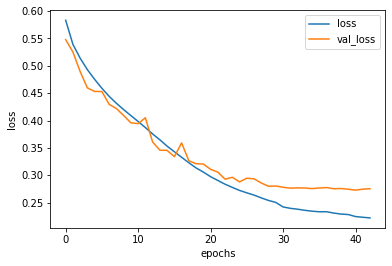

In [0]:
# load losses from local
import csv
loss = []
val_loss = []
with open('losses.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
      loss.append(float(row[0]))
      val_loss.append(float(row[1]))
        # loss.append((float)row))
        # print(row)
epochs = np.arange(len(loss))
print(loss)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
labels = ["loss","val_loss"]
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(labels,loc = "upper right")

In [0]:
# print the loss history in the model
for i in range(len(loss)):
  print("epochs  {0} loss: {1}  val_loss  {2}".format(i+1, loss[i], val_loss[i]))

epochs  1 loss: 0.5833239185090606  val_loss  0.5479436865750196
epochs  2 loss: 0.5392689951212867  val_loss  0.525249026720492
epochs  3 loss: 0.5139510468193659  val_loss  0.489516802676832
epochs  4 loss: 0.4929331028717114  val_loss  0.45962558403488035
epochs  5 loss: 0.4752719935157623  val_loss  0.45323426293023283
epochs  6 loss: 0.4589763726302253  val_loss  0.4530073797634583
epochs  7 loss: 0.4442545501416949  val_loss  0.429679864997403
epochs  8 loss: 0.43157764834938483  val_loss  0.42204896947493314
epochs  9 loss: 0.420018585449623  val_loss  0.40914464883567875
epochs  10 loss: 0.40910318182581856  val_loss  0.395912802530108
epochs  11 loss: 0.39828727468694874  val_loss  0.39436087741718423
epochs  12 loss: 0.38720173093634813  val_loss  0.4051278235422754
epochs  13 loss: 0.37550568086725333  val_loss  0.36081880084739243
epochs  14 loss: 0.3648246563998251  val_loss  0.34594174781879344
epochs  15 loss: 0.3531749500996262  val_loss  0.3454954899274386
epochs  16 l

In [0]:
# Train with previous best model
# model = Model(args)
# model.load('models/model_cpt.pth')
# model.train()

In [0]:
test_args = edict({'data_dir':'test',
                   'model_path':'models/model_cpt.pth', 
                   'output_directory':'test/2011_09_26_drive_0101_sync', 
                   'mode':'test'})

In [0]:
# Test with previous best model
model = Model(test_args)
model.test()

Use a dataset with 936 images
936
Finished Testing


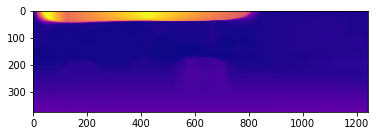

In [0]:
import skimage.transform
import matplotlib.pyplot as plt

disp = np.load('test/2011_09_26_drive_0101_sync/disparities_pp.npy')  # Or disparities.npy for output without post-processing
disp.shape
disp_to_img = skimage.transform.resize(disp[0].squeeze(), [375, 1242], mode='constant')
plt.imshow(disp_to_img, cmap='plasma')
plt.imsave(os.path.join(test_args.output_directory,
                        test_args.model_path.split('/')[-1][:-4]+'_test_output.png'), disp_to_img, cmap='plasma')

## Conclusion

### 1) Training Datasets:
Only the partial kitti dataset is used to train our model. The total size of kitti dataset is 175GB which is neither possible nor necessary for this project. Therefore, the chosen training dataset is of size 110GB that is about 2/3 portion of the whole dataset. As a result, the overall accuracy still have the room for improvement.

### 2) Loss
Due to the time and computational contraints, our network was only trained for 43 epochs with learning rate of 0.0001. The loss graph shows the validation loss starts to converge around the 30th epoch, and the training loss still keeps declining, which is arguably the sign of overfitting. In comparison with the original model Godard et al. presented, we simplify their architecture so that our network only produces one pair of disparity maps instead of four. Consequently, we observed that, with the same amount of data and training epoches, our final loss (~ 0.2) is about one quarter of the origianl loss (~ 0.9).

### 3) Prediction
For demonstration purposes, We generated two gif files from our testing results (Please find them in your unzipped folder or open the Juypter notebook). Our model preforms well when there exists different objects at different depth levels in the scene, for instance, trees, street lights and traffic signs.

From the second gif, We also observed that, the network could yield mispredictions in the photo-consistent areas where less occlusions are found. The sky tends to be considered as near oject somehow for its brighter color, whereas road that near the camera shows color in blue when referenced objects were absent. We may argue that parameter tuning in kernel size might mitigate this artifact since larger kernel could magnify the difference between patches, which leads to easy correspondence matching between stereo pairs.



# ![alt text](https://drive.google.com/uc?id=1Nq2Lk9ls8jN3-zOpZHMrUESLI8WNUYAp)
![alt text](https://drive.google.com/uc?id=1HVQBDJ2b68KwCwRBeKX8yykqvmq8b7QC)
